In [1]:
%matplotlib inline
import pyro
import torch
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display
from ffjord.lib.toy_data import inf_train_gen
from utils import plot_train_loss, plot_density
from models import GaussianMixtureModel, CPModel, TensorTrain

# Data

In [2]:
# Generate synthetic data
data_8g = torch.tensor(inf_train_gen('8gaussians', batch_size=5000),
                      dtype=torch.float)

data_cb = torch.tensor(inf_train_gen('checkerboard', batch_size=5000),
                      dtype=torch.float)

data_2s = torch.tensor(inf_train_gen('2spirals', batch_size=5000),
                      dtype=torch.float)

# Gaussian Mixture Model / CP Model

### 8 Gaussians

In [3]:
pyro.clear_param_store()
model = GaussianMixtureModel(K=8)
model.init_from_data(data_8g, k_means=True)
model.fit_model(data_8g, n_steps=15000)
print('Log likelihood of data:', model.log_likelihood(data_8g).item())

[iter 0]  loss: 22129.7812
[iter 1000]  loss: 20706.3379
[iter 2000]  loss: 19487.2266
[iter 3000]  loss: 17985.9258
[iter 4000]  loss: 15795.0479
[iter 5000]  loss: 14520.5352
[iter 6000]  loss: 14147.7666
[iter 7000]  loss: 14108.1123
[iter 8000]  loss: 14107.1230
[iter 9000]  loss: 14107.1289
[iter 10000]  loss: 14107.1328
[iter 11000]  loss: 14107.1328
[iter 12000]  loss: 14107.1318
[iter 13000]  loss: 14107.1328
[iter 14000]  loss: 14107.1279
Log likelihood of data: -14107.1220703125


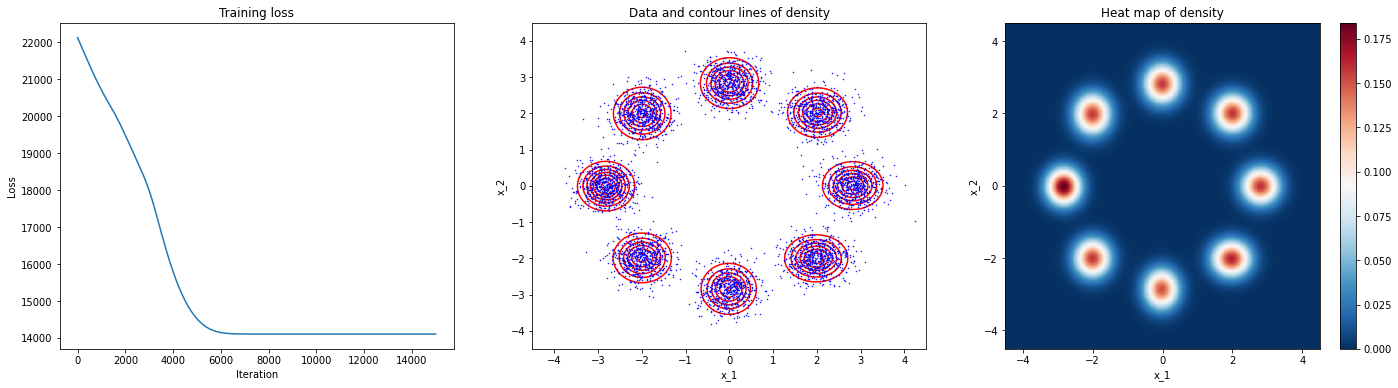

In [4]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(24, 6))
plot_train_loss(model, axes[0])
plot_density(model, data_8g, density_grid=[-4.5, 4.5, -4.5, 4.5], axes=axes[1:])

### Checkerboard

In [5]:
pyro.clear_param_store()
model = GaussianMixtureModel(K=8)
model.init_from_data(data_cb, k_means=True)
model.fit_model(data_cb, n_steps=15000)
print('Log likelihood of data:', model.log_likelihood(data_cb).item())

[iter 0]  loss: 23406.1914
[iter 1000]  loss: 22319.5762
[iter 2000]  loss: 21521.2305
[iter 3000]  loss: 20427.6250
[iter 4000]  loss: 19210.8223
[iter 5000]  loss: 18968.6113
[iter 6000]  loss: 18959.6270
[iter 7000]  loss: 18959.6230
[iter 8000]  loss: 18959.6230
[iter 9000]  loss: 18959.6230
[iter 10000]  loss: 18959.6230
[iter 11000]  loss: 18959.6270
[iter 12000]  loss: 18959.6250
[iter 13000]  loss: 18959.6270
[iter 14000]  loss: 18959.6250
Log likelihood of data: -18959.61328125


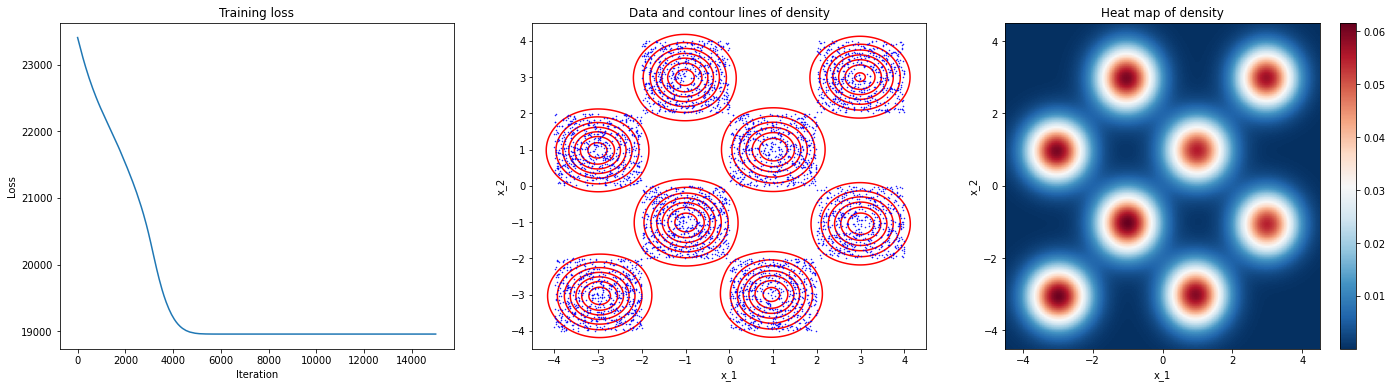

In [6]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(24, 6))
plot_train_loss(model, axes[0])
plot_density(model, data_cb, density_grid=[-4.5, 4.5, -4.5, 4.5], axes=axes[1:])

### 2 spirals

In [7]:
pyro.clear_param_store()
model = GaussianMixtureModel(K=8)
model.init_from_data(data_2s, k_means=True)
model.fit_model(data_2s, n_steps=15000)
print('Log likelihood of data:', model.log_likelihood(data_2s).item())

[iter 0]  loss: 19706.2070
[iter 1000]  loss: 18620.6445
[iter 2000]  loss: 18164.5352
[iter 3000]  loss: 17950.1094
[iter 4000]  loss: 17720.3359
[iter 5000]  loss: 17324.9355
[iter 6000]  loss: 17127.1172
[iter 7000]  loss: 17070.2031
[iter 8000]  loss: 17045.7832
[iter 9000]  loss: 17037.9473
[iter 10000]  loss: 17037.0566
[iter 11000]  loss: 17037.0078
[iter 12000]  loss: 17037.0039
[iter 13000]  loss: 17037.0020
[iter 14000]  loss: 17037.0020
Log likelihood of data: -17037.037109375


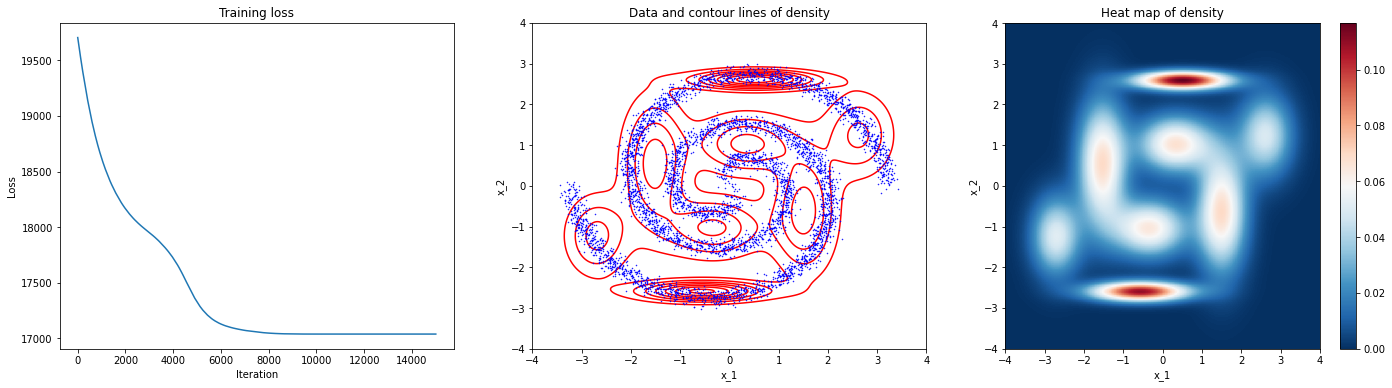

In [8]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(24, 6))
plot_train_loss(model, axes[0])
plot_density(model, data_2s, density_grid=[-4, 4, -4, 4], axes=axes[1:])

# Tensor Train Model

In [9]:
setups = [[2,2,2], [3,3,3], [4,4,4], [5,5,5], [6,6,6]]
n_restarts = 5

### 8 Gaussians

Ks: [2, 2, 2]
Best log likelihood: -16500.04


Ks: [3, 3, 3]
Best log likelihood: -14108.37


Ks: [4, 4, 4]
Best log likelihood: -14088.32


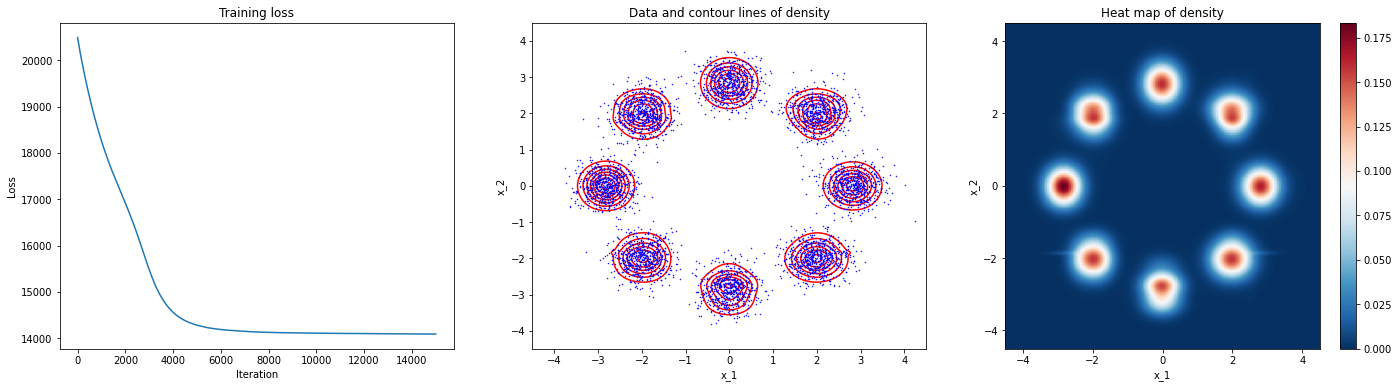

Ks: [5, 5, 5]
Best log likelihood: -14070.12


Ks: [6, 6, 6]
Best log likelihood: -14011.18


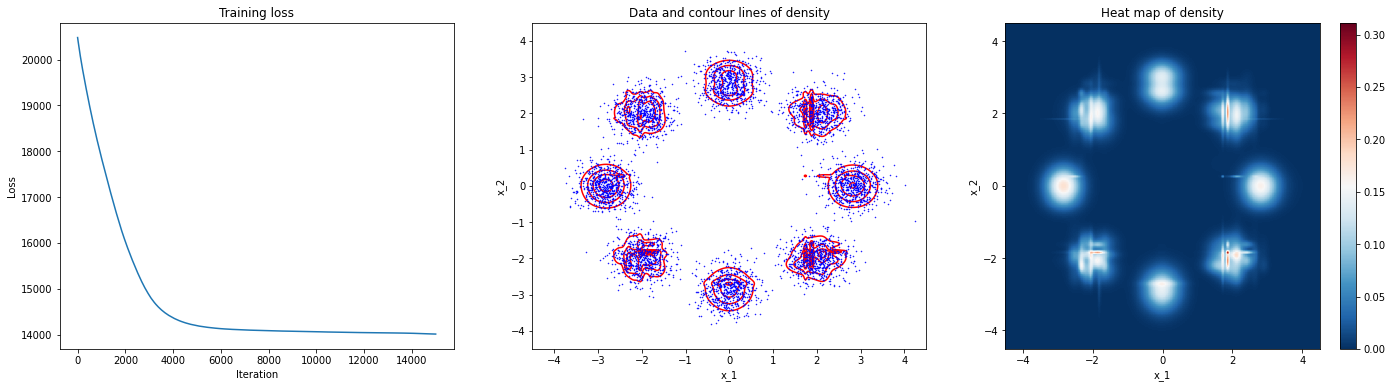

In [10]:
llh_8g = np.zeros((len(setups), n_restarts))
plots_8g = [[None for j in range(n_restarts)]
             for i in range(len(setups))]

for i, setup in enumerate(setups):
    for j in range(n_restarts):
        # Fit model
        pyro.clear_param_store()
        model = TensorTrain(Ks=setup)
        model.hot_start(data_8g, n_starts=500)
        model.fit_model(data_8g, n_steps=15000, verbose=False)
        
        # Save llh
        llh_8g[i,j] = model.log_likelihood(data_8g).item()
        
        # Create plots
        fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(24, 6))
        plot_train_loss(model, axes[0])
        plot_density(model, data_8g, 
                     density_grid=[-4.5, 4.5, -4.5, 4.5],
                     axes=axes[1:])
        # Save figure
        plots_8g[i][j] = fig
        plt.close()
    
    idx_best = np.argmax(llh_8g[i])
    print('Ks:', setup)
    print('Best log likelihood:', round(llh_8g[i, idx_best], 2))
    display(plots_8g[i][idx_best])

### Checkerboard 

Ks: [2, 2, 2]
Best log likelihood: -18964.96


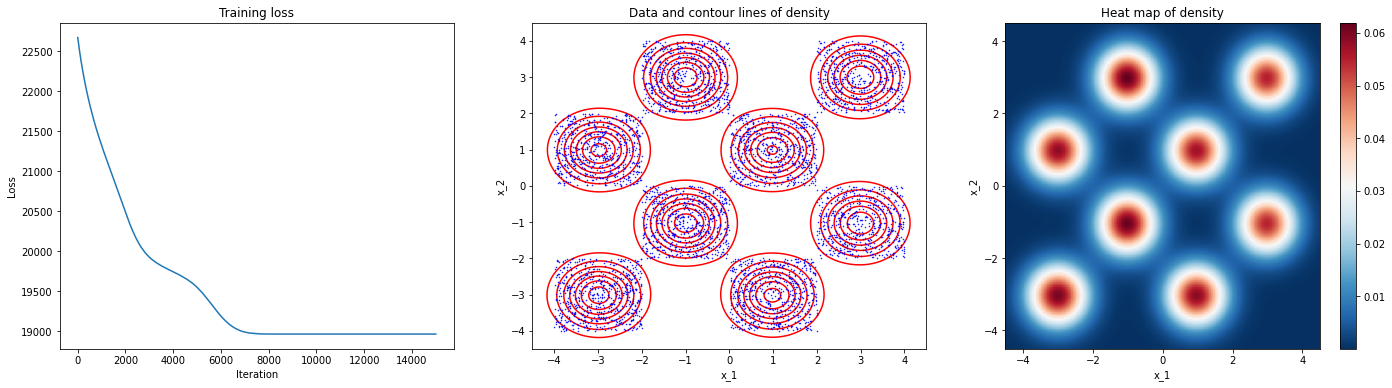

Ks: [3, 3, 3]
Best log likelihood: -18450.58


Ks: [4, 4, 4]
Best log likelihood: -18039.72


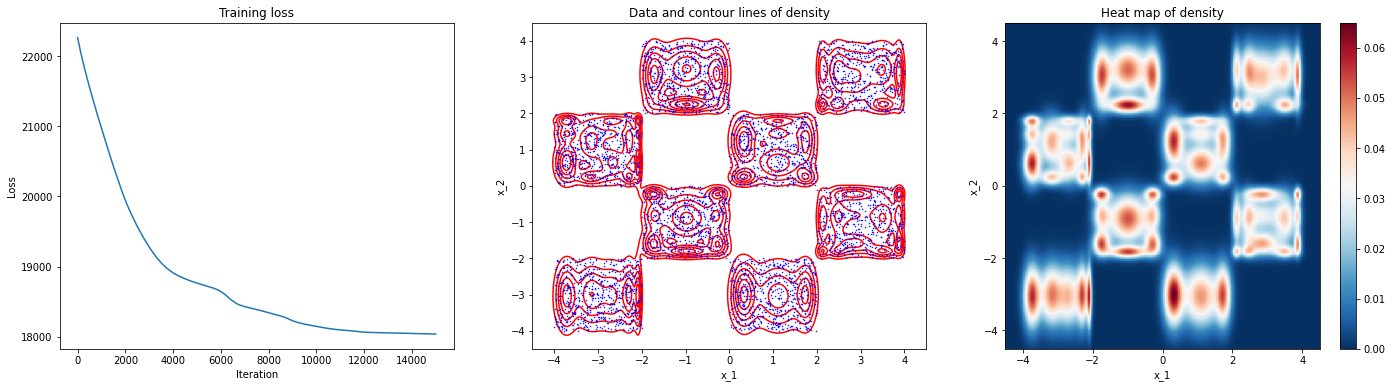

Ks: [5, 5, 5]
Best log likelihood: -17749.54


Ks: [6, 6, 6]
Best log likelihood: -17507.56


In [11]:
llh_cb = np.zeros((len(setups), n_restarts))
plots_cb = [[None for j in range(n_restarts)]
             for i in range(len(setups))]

for i, setup in enumerate(setups):
    for j in range(n_restarts):
        # Fit model
        pyro.clear_param_store()
        model = TensorTrain(Ks=setup)
        model.hot_start(data_cb, n_starts=500)
        model.fit_model(data_cb, n_steps=15000, verbose=False)
        
        # Save llh
        llh_cb[i,j] = model.log_likelihood(data_cb).item()
        
        # Create plots
        fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(24, 6))
        plot_train_loss(model, axes[0])
        plot_density(model, data_cb, 
                     density_grid=[-4.5, 4.5, -4.5, 4.5],
                     axes=axes[1:])
        # Save figure
        plots_cb[i][j] = fig
        plt.close()
    
    idx_best = np.argmax(llh_cb[i])
    print('Ks:', setup)
    print('Best log likelihood:', round(llh_cb[i, idx_best], 2))
    display(plots_cb[i][idx_best])

### 2 Spirals

Ks: [2, 2, 2]
Best log likelihood: -17699.68


Ks: [3, 3, 3]
Best log likelihood: -16743.33


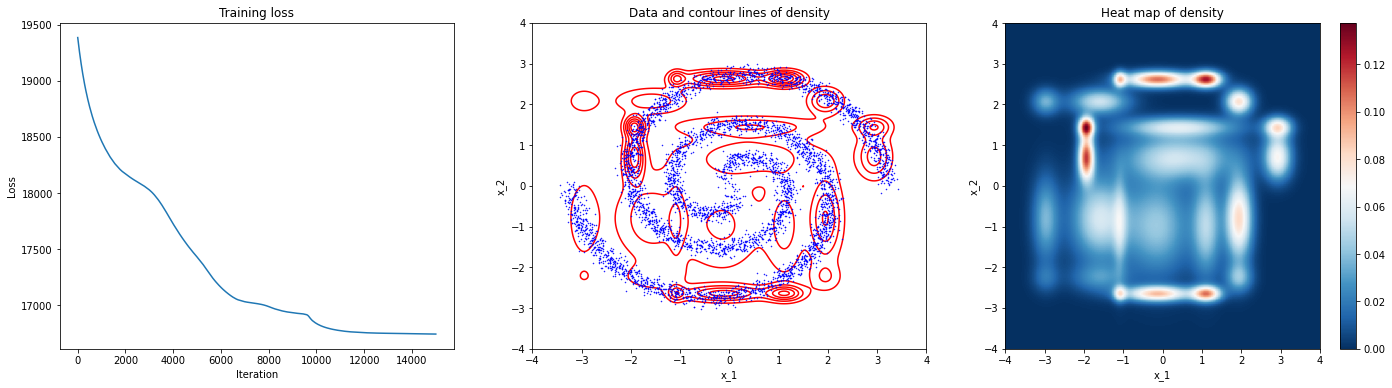

Ks: [4, 4, 4]
Best log likelihood: -16002.93


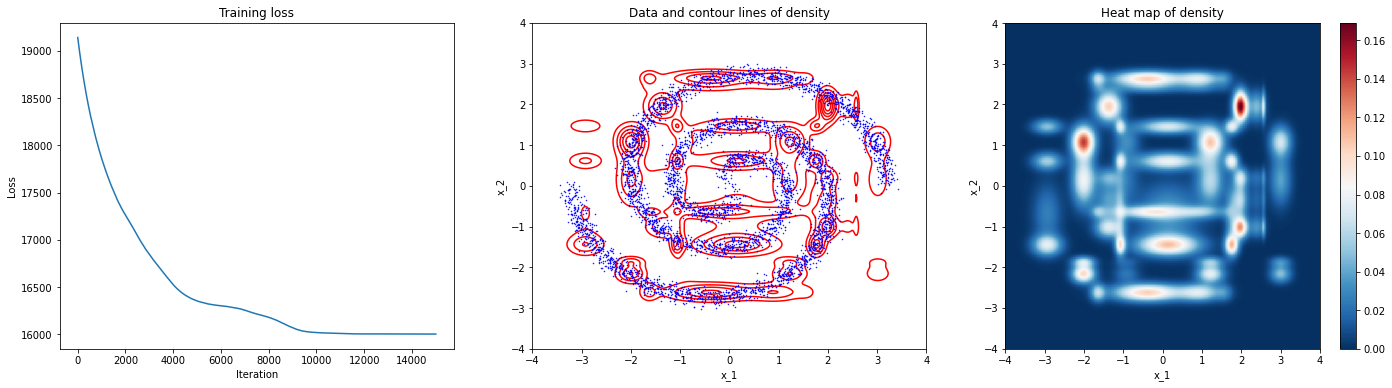

Ks: [5, 5, 5]
Best log likelihood: -15323.83


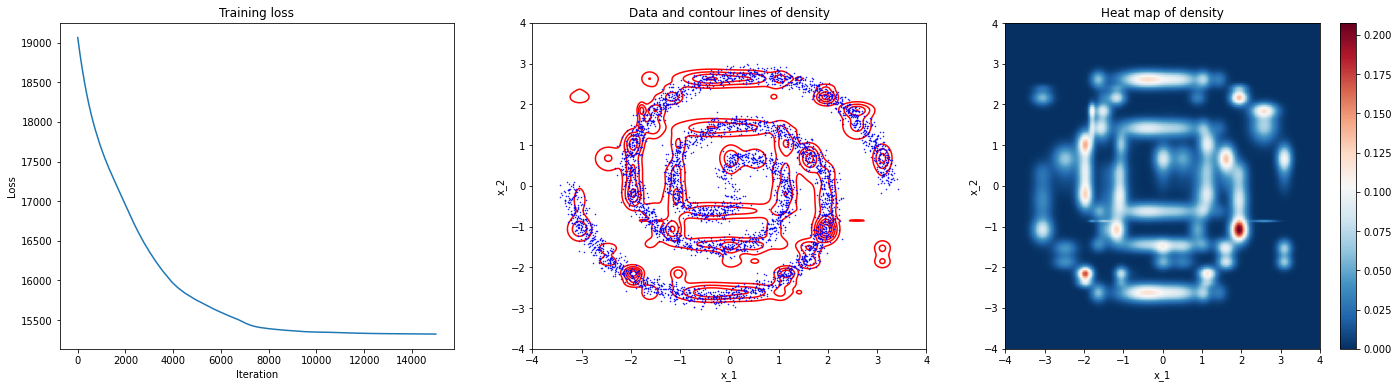

In [ ]:
llh_2s = np.zeros((len(setups), n_restarts))
plots_2s = [[None for j in range(n_restarts)]
             for i in range(len(setups))]

for i, setup in enumerate(setups):
    for j in range(n_restarts):
        # Fit model
        pyro.clear_param_store()
        model = TensorTrain(Ks=setup)
        model.hot_start(data_2s, n_starts=500)
        model.fit_model(data_2s, n_steps=15000, verbose=False)
        
        # Save llh
        llh_2s[i,j] = model.log_likelihood(data_2s).item()
        
        # Create plots
        fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(24, 6))
        plot_train_loss(model, axes[0])
        plot_density(model, data_2s, 
                     density_grid=[-4, 4, -4, 4],
                     axes=axes[1:])
        # Save figure
        plots_2s[i][j] = fig
        plt.close()
    
    idx_best = np.argmax(llh_2s[i])
    print('Ks:', setup)
    print('Best log likelihood:', round(llh_2s[i, idx_best], 2))
    display(plots_2s[i][idx_best])